In [1]:
from __future__ import division
import numpy as np
from numpy import exp
import epgcpmg as epg
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def numerical_gradient(myfun, myparams, e=1e-5):

    initial_params = myparams.copy()
    num_grad = np.zeros(initial_params.shape)
    perturb = np.zeros(initial_params.shape)
    
    for p in range(len(initial_params)):
        
        perturb[p] = e
        
        loss2 = myfun(myparams + perturb)
        loss1 = myfun(myparams - perturb)
        
        num_grad[p] = (loss2 - loss1) / (2 * e)
        
        perturb[p] = 0.

        return num_grad

In [3]:
def read_angles(fliptable):
    f = open(fliptable, 'r')
    angles = []
    for line in f.readlines():
        angles.append(float(line))
    f.close()
    return np.array(angles)

In [4]:
def T1_recovery(T, T1):
    return exp(-T/T1)

def T1_recovery_prime(T, T1):
    return T * exp(-T/T1) / T1**2

def t1t2shuffle(angles_rad, TE, TRs, M0, T1, T2):

    URs = TRs - (T+1)*TE # T + 1 to account for fast recovery

    fi = epg.FSE_signal(angles_rad, TE, T1, T2)
    Ej = T1_recovery(URs, T1)[None,:]

    sig = M0 * fi * (1 - Ej) / (1 - fi[-1]*Ej)
    
    return sig.ravel(order='F')
    
def t1t2shuffle_prime_T2(angles_rad, TE, TRs, M0, T1, T2):
    """derivative of signal equation w.r.t. T2"""

    URs = TRs - (T+1)*TE # T + 1 to account for fast recovery

    fi = epg.FSE_signal(angles_rad, TE, T1, T2)
    fi_prime = epg.FSE_signal_prime_T2(angles_rad, TE, T1, T2)
    
    Ej = T1_recovery(URs, T1)[None,:]
    
    sig_prime = M0 * (1 - Ej) * (fi_prime * (1 - Ej*fi[-1]) + Ej*fi_prime[-1]*fi) / (1 - Ej*fi[-1])**2
    
    return sig_prime.ravel(order='F')

def t1t2shuffle_prime_T1(angles_rad, TE, TRs, M0, T1, T2):
    """derivative of signal equation w.r.t. T1"""
    
    URs = TRs - (T+1)*TE # T + 1 to account for fast recovery
    
    fi = epg.FSE_signal(angles_rad, TE, T1, T2)
    fi_prime = epg.FSE_signal_prime_T1(angles_rad, TE, T1, T2)
    
    Ej = T1_recovery(URs, T1)[None,:] 
    Ej_prime = T1_recovery_prime(URs, T1)[None, :]
    
    sig_prime = M0 * ((fi_prime*(1 - Ej) - Ej_prime*fi) * (1 - Ej*fi[-1]) + (Ej_prime*fi[-1] + Ej*fi_prime[-1])*fi*(1-Ej)) / (1 - Ej*fi[-1])**2
    
    return sig_prime.ravel(order='F')

def t1t2shuffle_prime_M0(angles_rad, TE, TRs, M0, T1, T2):
    """derivative of signal equation w.r.t. M0"""
    
    return t1t2shuffle(angles_rad, TE, TRs, 1., T1, T2)
    

forward model time: 0.00294184684753
T2 derivative time: 0.00545287132263
T1 derivative time: 0.00519800186157
M0 derivative time: 0.00154709815979
numerical grad time: 0.557424068451
T1 numerical vs prop gradient error: 2.97105966627e-08
T2 numerical vs prop gradient error: 1.36822365937e-08
M0 numerical vs prop gradient error: 6.49691012518e-12


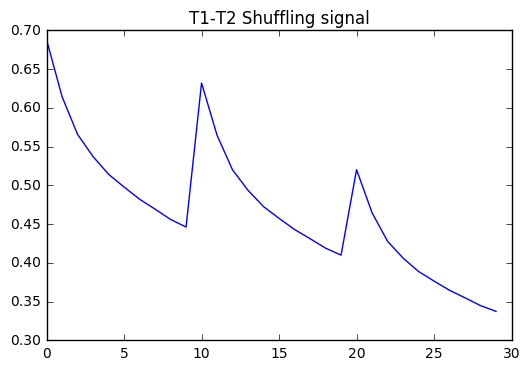

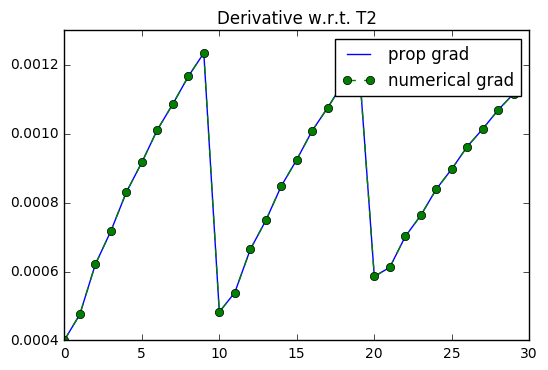

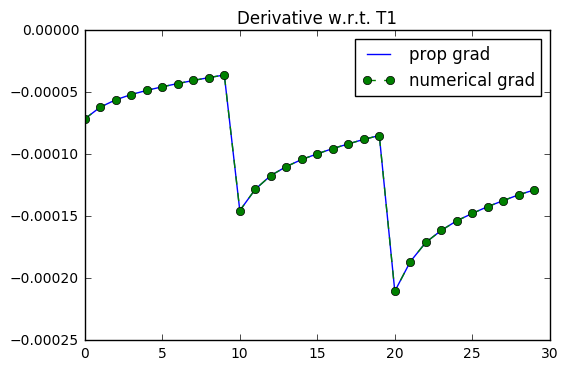

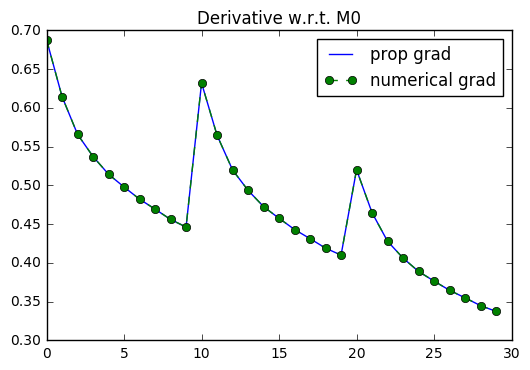

In [5]:
M0 = 1;
T1 = 1000
T2 = 100
TE = 5

TRs = np.array([2800, 1700, 950])
N = len(TRs)

T = 10

echo_times = np.arange(TE, TE*(T+1), TE)

angles_rad = 120 * np.ones((T,)) * np.pi/180
angles_rad = np.pi/180 * read_angles('flipangles.txt.814192544')[:T]

tic = time.time()
sig = t1t2shuffle(angles_rad, TE, TRs, M0, T1, T2)
toc = time.time()

print 'forward model time:', toc - tic

tic = time.time()
sig_prime_T2 = t1t2shuffle_prime_T2(angles_rad, TE, TRs, M0, T1, T2)
toc = time.time()

print 'T2 derivative time:', toc - tic

tic = time.time()
sig_prime_T1 = t1t2shuffle_prime_T1(angles_rad, TE, TRs, M0, T1, T2)
toc = time.time()

print 'T1 derivative time:', toc - tic

tic = time.time()
sig_prime_M0 = t1t2shuffle_prime_M0(angles_rad, TE, TRs, M0, T1, T2)
toc = time.time()

print 'M0 derivative time:', toc - tic


tic = time.time()
w1_num = np.zeros((T,N))
w2_num = np.zeros((T,N))
w0_num = np.zeros((T,N))
for i in range(T):
    for j in range(N):
        w2_num[i,j] = numerical_gradient(lambda x: t1t2shuffle(angles_rad, TE, np.array([TRs[j]]), M0, T1, x)[i], np.array([T2]))
        w1_num[i,j] = numerical_gradient(lambda x: t1t2shuffle(angles_rad, TE, np.array([TRs[j]]), M0, x, T2)[i], np.array([T1]))
        w0_num[i,j] = numerical_gradient(lambda x: t1t2shuffle(angles_rad, TE, np.array([TRs[j]]), x, T1, T2)[i], np.array([1]))
toc = time.time()
print 'numerical grad time:', toc-tic

print 'T1 numerical vs prop gradient error:', np.linalg.norm(w1_num.ravel(order='F') - sig_prime_T1.T) / np.linalg.norm(sig_prime_T1)
print 'T2 numerical vs prop gradient error:', np.linalg.norm(w2_num.ravel(order='F') - sig_prime_T2.T) / np.linalg.norm(sig_prime_T2)
print 'M0 numerical vs prop gradient error:', np.linalg.norm(w0_num.ravel(order='F') - sig_prime_M0.T) / np.linalg.norm(sig_prime_M0)

plt.figure()
plt.plot(range(T*N), sig)
plt.title('T1-T2 Shuffling signal')

plt.figure()
plt.plot(range(T*N), sig_prime_T2, range(T*N), w2_num.ravel(order='F'), '--o')
plt.title('Derivative w.r.t. T2')
plt.legend(('prop grad', 'numerical grad'))

plt.figure()
plt.plot(range(T*N), sig_prime_T1, range(T*N), w1_num.ravel(order='F'), '--o')
plt.title('Derivative w.r.t. T1')
plt.legend(('prop grad', 'numerical grad'))

plt.figure()
plt.plot(range(T*N), sig_prime_M0, range(T*N), w0_num.ravel(order='F'), '--o')
plt.title('Derivative w.r.t. M0')
plt.legend(('prop grad', 'numerical grad'))

In [6]:
def fisher_prime_entry(myfun0, myfun1, angles_rad, TE, TRs, M0, T1, T2):
    t = myfun0(angles_rad, TE, TRs, M0, T1, T2)
    if myfun0 is myfun1:
        t *=t
    else:
        t *= myfun1(angles_rad, TE, TRs, M0, T1, T2)
    return np.sum(t)
           
def fisher_prime_M0_M0(angles_rad, TE, TRs, M0, T1, T2):
    return fisher_prime_entry(t1t2shuffle_prime_M0, t1t2shuffle_prime_M0, angles_rad, TE, TRs, M0, T1, T2)

def fisher_prime_M0_T1(angles_rad, TE, TRs, M0, T1, T2):
    return fisher_prime_entry(t1t2shuffle_prime_M0, t1t2shuffle_prime_T1, angles_rad, TE, TRs, M0, T1, T2)

def fisher_prime_M0_T2(angles_rad, TE, TRs, M0, T1, T2):
    return fisher_prime_entry(t1t2shuffle_prime_M0, t1t2shuffle_prime_T2, angles_rad, TE, TRs, M0, T1, T2)

def fisher_prime_T1_T1(angles_rad, TE, TRs, M0, T1, T2):
    return fisher_prime_entry(t1t2shuffle_prime_T1, t1t2shuffle_prime_T1, angles_rad, TE, TRs, M0, T1, T2)

def fisher_prime_T1_T2(angles_rad, TE, TRs, M0, T1, T2):
    return fisher_prime_entry(t1t2shuffle_prime_T1, t1t2shuffle_prime_T2, angles_rad, TE, TRs, M0, T1, T2)

def fisher_prime_T2_T2(angles_rad, TE, TRs, M0, T1, T2):    
    return fisher_prime_entry(t1t2shuffle_prime_T2, t1t2shuffle_prime_T2, angles_rad, TE, TRs, M0, T1, T2)


In [7]:
a11 = fisher_prime_M0_M0(angles_rad, TE, TRs, M0, T1, T2)
a12 = fisher_prime_M0_T1(angles_rad, TE, TRs, M0, T1, T2)
a13 = fisher_prime_M0_T2(angles_rad, TE, TRs, M0, T1, T2)
a22 = fisher_prime_T1_T1(angles_rad, TE, TRs, M0, T1, T2)
a23 = fisher_prime_T1_T2(angles_rad, TE, TRs, M0, T1, T2)
a33 = fisher_prime_T2_T2(angles_rad, TE, TRs, M0, T1, T2)


FIM = np.array([[a11, a12, a13], [a12, a22, a23], [a13, a23, a33]])
print FIM

[[  6.84485065e+00  -1.43371712e-03   1.16269386e-02]
 [ -1.43371712e-03   3.94256417e-07  -2.56744524e-06]
 [  1.16269386e-02  -2.56744524e-06   2.36082917e-05]]
